# Кластеризация криптовалют: Поведенческие отличия от Биткоина (2025)

## Цель
Найти и выделить криптовалюты, которые демонстрируют **ценовое поведение, существенно отличное от биткоина**, используя современные методы анализа временных рядов и кластеризации.

---

**Методы:**  
- KMeans, Time Series KMeans  
- Dynamic Time Warping (ShapeDTW, SoftDTW, FastDTW)  
- Feature Clustering (PCA, HDBSCAN, UMAP/TSNE)  
- Сравнение с доминацией BTC

---

**Этапы:**
1. Загрузка данных (Binance API)
2. Обогащение признаков (доходность, волатильность, RSI, beta, PCA)
3. Кластеризация (несколько подходов)
4. Визуализация
5. Проверка гипотез: поведение кластеров при изменении доминации BTC
6. Автоматизация для будущих алертов

2. Импорты и вспомогательные функции

In [42]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans, KShape, silhouette_score
from tslearn.metrics import soft_dtw
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
import hdbscan
import umap

import warnings
warnings.filterwarnings("ignore")

3. Загрузка данных с Binance API

In [53]:
# 1. Импорт библиотек
import requests
import pandas as pd
from time import sleep

# 2. Получение всех USDT-тикеров
def get_all_usdt_symbols():
    url = "https://api.binance.com/api/v3/exchangeInfo"
    data = requests.get(url).json()
    symbols = [
        s['symbol'] for s in data['symbols']
        if s['quoteAsset'] == 'USDT' and s['status'] == 'TRADING'
    ]
    print(f"Всего найдено {len(symbols)} активов с USDT")
    return symbols

all_symbols = get_all_usdt_symbols()   # ← теперь твой глобальный список

# 3. Функция загрузки данных
def get_recent_klines(symbol, interval='1d', lookback_days=1000):
    url = "https://api.binance.com/api/v3/klines"
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': lookback_days
    }
    try:
        response = requests.get(url, params=params, timeout=10)
        data = response.json()
        df = pd.DataFrame(data, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_asset_volume', 'num_trades',
            'taker_buy_base', 'taker_buy_quote', 'ignore'
        ])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['close'] = df['close'].astype(float)
        df['volume'] = df['volume'].astype(float)
        return df[['timestamp', 'close', 'volume']]
    except Exception as e:
        print(f"{symbol}: ошибка ({e})")
        return pd.DataFrame(columns=['timestamp', 'close', 'volume'])

# 4. Основной цикл — скачиваем все тикеры (заменяет цикл по топ-100)
all_data = {}
for i, sym in enumerate(all_symbols):
    print(f"[{i+1:03d}/{len(all_symbols)}] Loading {sym}...", end=' ')
    df = get_recent_klines(sym, interval='1d', lookback_days=1000)
    if not df.empty:
        all_data[sym] = df
        print("OK")
    else:
        print("FAIL")
    sleep(0.25)  # чтобы не словить бан

print(f"\nСкачано данных по {len(all_data)} из {len(all_symbols)} монет.")


Всего найдено 400 активов с USDT
[001/400] Loading BTCUSDT... OK
[002/400] Loading ETHUSDT... OK
[003/400] Loading BNBUSDT... OK
[004/400] Loading NEOUSDT... OK
[005/400] Loading LTCUSDT... OK
[006/400] Loading QTUMUSDT... OK
[007/400] Loading ADAUSDT... OK
[008/400] Loading XRPUSDT... OK
[009/400] Loading TUSDUSDT... OK
[010/400] Loading IOTAUSDT... OK
[011/400] Loading XLMUSDT... OK
[012/400] Loading ONTUSDT... OK
[013/400] Loading TRXUSDT... OK
[014/400] Loading ETCUSDT... OK
[015/400] Loading ICXUSDT... OK
[016/400] Loading VETUSDT... OK
[017/400] Loading USDCUSDT... OK
[018/400] Loading LINKUSDT... OK
[019/400] Loading ONGUSDT... OK
[020/400] Loading HOTUSDT... OK
[021/400] Loading ZILUSDT... OK
[022/400] Loading ZRXUSDT... OK
[023/400] Loading FETUSDT... OK
[024/400] Loading BATUSDT... OK
[025/400] Loading ZECUSDT... OK
[026/400] Loading IOSTUSDT... OK
[027/400] Loading CELRUSDT... OK
[028/400] Loading DASHUSDT... OK
[029/400] Loading THETAUSDT... OK
[030/400] Loading ENJUSDT... 

4. Обогащение признаков (feature engineering)

In [54]:
def compute_features(df, window=14, btc_close=None):
    # Доходность
    df['returns'] = df['close'].pct_change()
    # Скользящее std — волатильность
    df['volatility'] = df['returns'].rolling(window).std()
    # RSI
    df['rsi'] = RSIIndicator(df['close'], window=window).rsi()
    # ATR как альтернатива волатильности
    # Если есть high/low/close — можно добавить ta.volatility.AverageTrueRange
    # Beta к BTC
    if btc_close is not None:
        aligned = df['close'].pct_change().dropna().align(btc_close.pct_change().dropna(), join='inner')
        if len(aligned[0]) > 0 and len(aligned[1]) > 0:
            cov = np.cov(aligned[0], aligned[1])[0][1]
            var = np.var(aligned[1])
            df['beta_btc'] = cov / var if var != 0 else 0
        else:
            df['beta_btc'] = 0
    else:
        df['beta_btc'] = 0
    return df

btc_close = all_data['BTCUSDT']['close']

for sym, df in all_data.items():
    all_data[sym] = compute_features(df, btc_close=btc_close)


5. Формируем датафрейм признаков для кластеризации

In [55]:
# Формируем на одну дату — последний available срез
features = []
date_col = 'timestamp'
last_date = min([df[date_col].max() for df in all_data.values()])

for sym, df in all_data.items():
    row = df[df[date_col] == last_date]
    if len(row):
        features.append({
            'symbol': sym,
            'close': row['close'].values[0],
            'volatility': row['volatility'].values[0],
            'rsi': row['rsi'].values[0],
            'beta_btc': row['beta_btc'].values[0],
            'volume': row['volume'].values[0]
        })

df_feat = pd.DataFrame(features).dropna().set_index('symbol')
df_feat.head()


,close,volatility,rsi,beta_btc,volume
symbol,,,,,
BTCUSDT,109481.91,0.017217,66.917679,1.001002,9679.14179
ETHUSDT,2628.89,0.024185,67.342259,1.053054,389345.42430
BNBUSDT,680.09,0.019123,63.429995,0.703808,137532.39400
NEOUSDT,6.62,0.036396,52.248647,1.165280,300793.94000
LTCUSDT,95.11,0.028767,50.618330,0.908320,217064.09900


In [56]:
import pandas as pd

# df_feat — твой датафрейм с фичами по всем монетам (уже был пример его формирования)
# Например:
# df_feat = pd.DataFrame(features).set_index('symbol')

pd.set_option('display.max_rows', 100)  # показать до 100 строк
print(df_feat)

                 close  volatility        rsi  beta_btc        volume
symbol                                                               
BTCUSDT    109481.9100    0.017217  66.917679  1.001002  9.679142e+03
ETHUSDT      2628.8900    0.024185  67.342259  1.053054  3.893454e+05
BNBUSDT       680.0900    0.019123  63.429995  0.703808  1.375324e+05
NEOUSDT         6.6200    0.036396  52.248647  1.165280  3.007939e+05
LTCUSDT        95.1100    0.028767  50.618330  0.908320  2.170641e+05
...                ...         ...        ...       ...           ...
SIGNUSDT        0.0798    0.052338  45.731236 -0.439042  1.190093e+07
STOUSDT         0.1206    0.057161  37.858673  0.372560  1.912905e+07
SYRUPUSDT       0.4274    0.067604  73.166696  0.433835  1.832539e+07
KMNOUSDT        0.0667    0.059078  42.406059 -0.106346  8.169068e+06
SXTUSDT         0.1203    0.112291  43.716519 -1.519941  2.716057e+07

[395 rows x 5 columns]


In [57]:
# Самые низкие beta_btc (самые “антибиткоины”)
best10 = df_feat.sort_values('beta_btc').head(10)
print("Топ-10 монет с минимальной зависимостью от BTC:")
print(best10)

Топ-10 монет с минимальной зависимостью от BTC:
              close  volatility        rsi  beta_btc      volume
symbol                                                          
SXTUSDT     0.12030    0.112291  43.716519 -1.519941  27160570.9
REDUSDT     0.42510    0.041789  50.334590 -0.809353  12164479.4
AIXBTUSDT   0.20820    0.082914  58.267446 -0.794432  69370257.0
GUNUSDT     0.04913    0.066078  43.255517 -0.595476  26085102.0
WCTUSDT     0.74630    0.106353  69.265574 -0.584844  19158910.9
COOKIEUSDT  0.27400    0.142206  66.934995 -0.449187  86951074.7
SIGNUSDT    0.07980    0.052338  45.731236 -0.439042  11900932.0
COWUSDT     0.41370    0.074844  57.332351 -0.420080   2800954.9
CGPTUSDT    0.13840    0.067130  58.622112 -0.329969  17570908.1
PARTIUSDT   0.25250    0.061892  45.810215 -0.272051   7232954.4


6. Стандартизация, PCA и базовая кластеризация KMeans

In [58]:
most_volatile = df_feat.sort_values('volatility', ascending=False).head(10)
print("Топ-10 по волатильности:")
print(most_volatile)


Топ-10 по волатильности:
               close  volatility        rsi  beta_btc        volume
symbol                                                             
NEIROUSDT   0.000524    0.150111  55.961480 -0.066778  4.082813e+10
COOKIEUSDT  0.274000    0.142206  66.934995 -0.449187  8.695107e+07
FLMUSDT     0.051100    0.118912  69.638822  1.235206  1.166160e+08
LISTAUSDT   0.295800    0.114315  71.623780  0.097542  1.349279e+07
PEOPLEUSDT  0.024690    0.112749  54.578372  1.334424  1.658092e+08
SXTUSDT     0.120300    0.112291  43.716519 -1.519941  2.716057e+07
INITUSDT    0.947900    0.111989  50.182342 -0.223612  9.250238e+06
WCTUSDT     0.746300    0.106353  69.265574 -0.584844  1.915891e+07
PORTALUSDT  0.061800    0.105484  42.842354  0.097775  1.737418e+07
BIOUSDT     0.083100    0.104692  52.361305 -0.186505  2.729866e+07


In [59]:
most_liquid = df_feat.sort_values('volume', ascending=False).head(10)
print("Топ-10 по объёму торгов:")
print(most_liquid)


Топ-10 по объёму торгов:
                     close  volatility        rsi  beta_btc        volume
symbol                                                                   
PEPEUSDT      1.404000e-05    0.068557  61.104974 -0.106906  9.765362e+12
SHIBUSDT      1.448000e-05    0.037097  50.576666  1.183070  8.563449e+11
BONKUSDT      2.061000e-05    0.065012  52.893549 -0.164414  5.934276e+11
BTTCUSDT      7.300000e-07    0.030103  49.247663  0.829080  2.939781e+11
FLOKIUSDT     1.011200e-04    0.061398  55.401440 -0.165482  7.511962e+10
1000SATSUSDT  5.500000e-05    0.084181  53.801098  0.007434  6.893315e+10
NEIROUSDT     5.241800e-04    0.150111  55.961480 -0.066778  4.082813e+10
XECUSDT       2.207000e-05    0.032402  45.794347  1.137100  1.876057e+10
LUNCUSDT      6.340000e-05    0.036899  50.356373 -0.113290  1.298448e+10
DOGSUSDT      1.857000e-04    0.072041  51.261329  0.050983  4.624023e+09


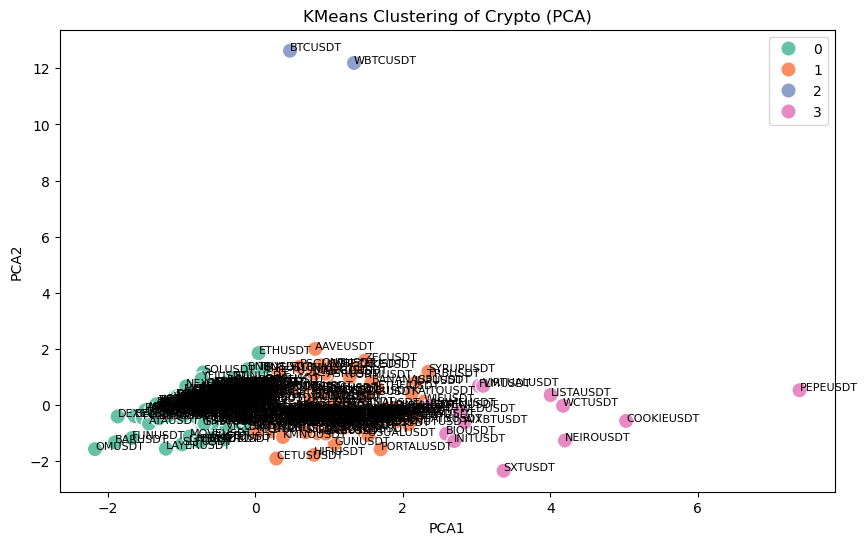

In [60]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feat)

# PCA до 2 компонент для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_pca)
df_feat['cluster_kmeans'] = labels

# Визуализация
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, s=120, palette='Set2', legend='full')
for i, txt in enumerate(df_feat.index):
    plt.text(X_pca[i,0], X_pca[i,1], txt, fontsize=8)
plt.title("KMeans Clustering of Crypto (PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


7. Time Series Clustering (TS KMeans, ShapeDTW/SoftDTW, HDBSCAN, UMAP)

ACXUSDT пропущен (мало данных)
ORCAUSDT пропущен (мало данных)
MOVEUSDT пропущен (мало данных)
MEUSDT пропущен (мало данных)
VELODROMEUSDT пропущен (мало данных)
VANAUSDT пропущен (мало данных)
1000CATUSDT пропущен (мало данных)
PENGUUSDT пропущен (мало данных)
BIOUSDT пропущен (мало данных)
DUSDT пропущен (мало данных)
AIXBTUSDT пропущен (мало данных)
CGPTUSDT пропущен (мало данных)
COOKIEUSDT пропущен (мало данных)
SUSDT пропущен (мало данных)
SOLVUSDT пропущен (мало данных)
TRUMPUSDT пропущен (мало данных)
ANIMEUSDT пропущен (мало данных)
BERAUSDT пропущен (мало данных)
1000CHEEMSUSDT пропущен (мало данных)
TSTUSDT пропущен (мало данных)
LAYERUSDT пропущен (мало данных)
HEIUSDT пропущен (мало данных)
KAITOUSDT пропущен (мало данных)
SHELLUSDT пропущен (мало данных)
REDUSDT пропущен (мало данных)
GPSUSDT пропущен (мало данных)
EPICUSDT пропущен (мало данных)
BMTUSDT пропущен (мало данных)
FORMUSDT пропущен (мало данных)
XUSDUSDT пропущен (мало данных)
NILUSDT пропущен (мало данных)
P

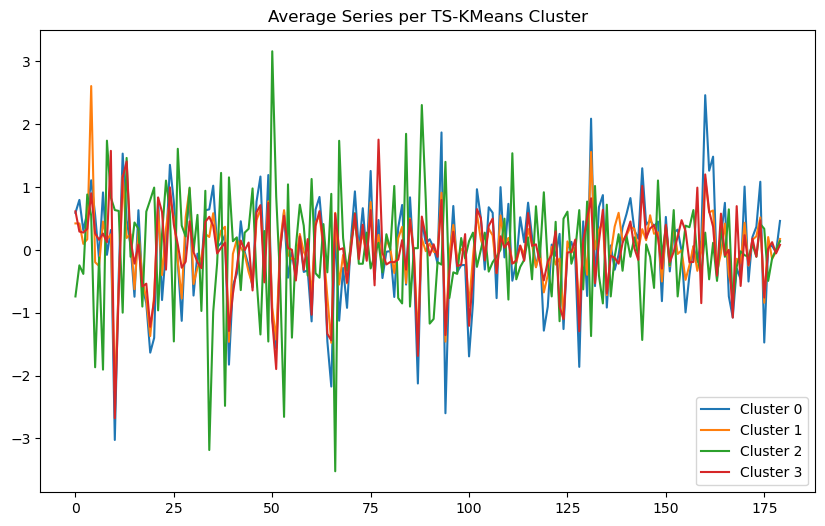

In [61]:
# Для TS KMeans (по ряду доходностей)
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Формируем матрицу временных рядов
series_matrix = []
for sym, df in all_data.items():
    arr = df['returns'].dropna().values[-180:]  # 180 дней
    if len(arr) == 180:
        series_matrix.append(arr)
    else:
        print(f"{sym} пропущен (мало данных)")

series_matrix = np.array(series_matrix)
series_matrix = TimeSeriesScalerMeanVariance().fit_transform(series_matrix)

# TimeSeriesKMeans (euclidean)
ts_kmeans = TimeSeriesKMeans(n_clusters=4, metric="euclidean", random_state=42, n_jobs=-1)
ts_labels = ts_kmeans.fit_predict(series_matrix)

# Визуализация кластеров
plt.figure(figsize=(10,6))
for yi in range(4):
    plt.plot(series_matrix[ts_labels==yi].mean(axis=0), label=f"Cluster {yi}")
plt.title("Average Series per TS-KMeans Cluster")
plt.legend()
plt.show()



8. Проверка гипотезы: влияние доминации BTC

In [62]:
# Получаем данные о доминации BTC (через CoinGecko или CMC API)
def get_btc_dominance(days=365):
    url = f"https://api.coingecko.com/api/v3/global"
    response = requests.get(url).json()
    return response['data']['market_cap_percentage']['btc']

btc_dominance = get_btc_dominance()
print(f"BTC Dominance: {btc_dominance:.2f}%")


BTC Dominance: 60.96%


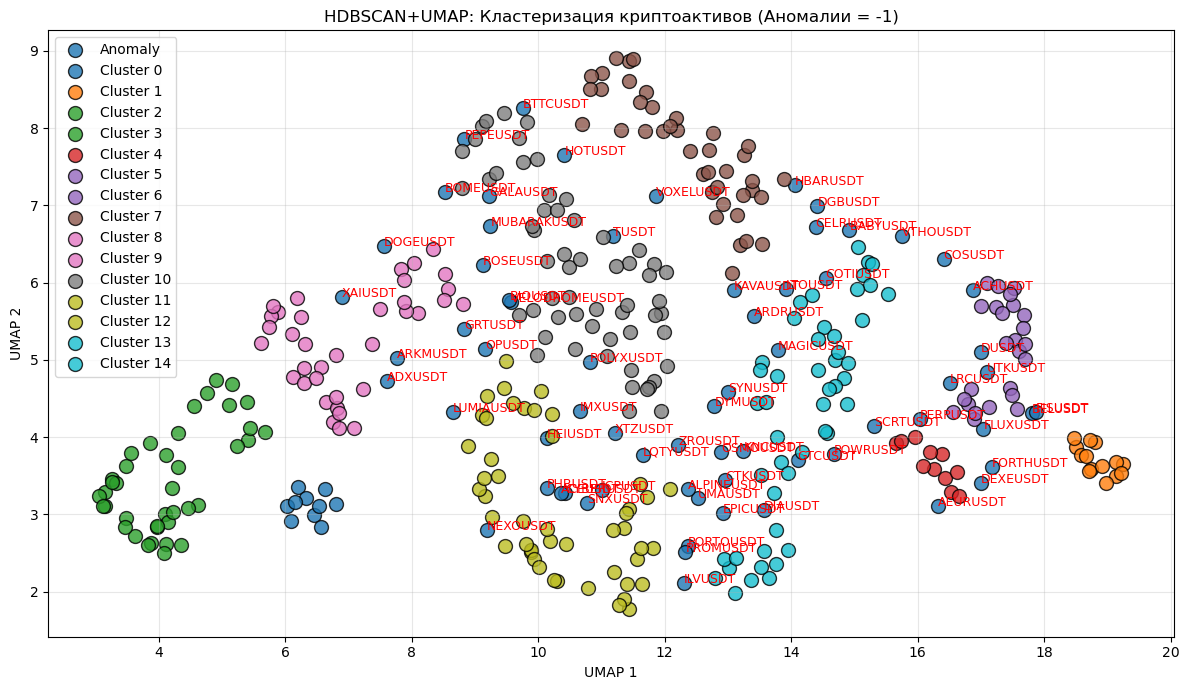

,close,volatility,rsi,beta_btc,volume,cluster_kmeans,umap1,umap2,cluster
symbol,,,,,,,,,
PORTOUSDT,1.059000,0.026933,49.308136,0.743049,124854.24,0,12.363306,2.584702,-1
SNXUSDT,0.793000,0.043929,51.308064,1.271476,582676.10,0,10.778498,3.140266,-1
TUSDT,0.017580,0.031539,49.917243,1.113289,23822784.80,0,11.185162,6.607116,-1
NEXOUSDT,1.267000,0.016832,54.459760,0.850712,362558.47,0,9.188643,2.795739,-1
LRCUSDT,0.101400,0.039046,44.686854,1.194975,5256505.00,0,16.513041,4.706223,-1
...,...,...,...,...,...,...,...,...,...
BIGTIMEUSDT,0.073040,0.049178,46.318618,-0.077244,8423004.00,1,15.049146,5.916797,14
PARTIUSDT,0.252500,0.061892,45.810215,-0.272051,7232954.40,1,15.241589,5.967864,14
XUSDUSDT,0.999700,0.000148,44.989623,0.000983,6065232.00,0,15.529943,5.847115,14


In [63]:
import pandas as pd
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt

# 1. Формируем таблицу признаков (пример, как у тебя)
# df_feat — итоговая таблица со всеми монетами (symbol — индекс)
# Например, df_feat = pd.DataFrame(features).set_index('symbol')

# Можно взять только ключевые признаки для кластеризации:
X = df_feat[['volatility', 'rsi', 'beta_btc', 'volume']].copy()

# (по желанию) log-скейлинг для объёма
X['volume'] = np.log1p(X['volume'])

# 2. Снижение размерности (UMAP)
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.3)
X_umap = reducer.fit_transform(X)

# 3. Кластеризация HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
labels = clusterer.fit_predict(X_umap)

# 4. Визуализация кластеров и аномалий
plt.figure(figsize=(12,7))
palette = plt.cm.tab10(np.linspace(0, 1, len(set(labels))))
for i, label in enumerate(np.unique(labels)):
    mask = labels == label
    label_name = f"Cluster {label}" if label != -1 else "Anomaly"
    plt.scatter(X_umap[mask,0], X_umap[mask,1], 
                s=100, c=[palette[i]], label=label_name, alpha=0.8, edgecolors='k')

# Добавляем тикеры только для аномалий
for idx, sym in enumerate(df_feat.index):
    if labels[idx] == -1:
        plt.text(X_umap[idx,0], X_umap[idx,1], sym, fontsize=9, color='red')

plt.title("HDBSCAN+UMAP: Кластеризация криптоактивов (Аномалии = -1)")
plt.xlabel("UMAP 1"); plt.ylabel("UMAP 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (опционально) Таблица с кластерами:
df_feat['umap1'] = X_umap[:,0]
df_feat['umap2'] = X_umap[:,1]
df_feat['cluster'] = labels
display(df_feat.sort_values('cluster'))
